In [1]:
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot  as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import auc, roc_curve, roc_auc_score
from sklearn.model_selection import train_test_split, GridSearchCV

from lifelines import CoxPHFitter 
import forestplot as fb

In [2]:
df = pd.read_csv('tyg3.csv')
df.head()

,subject_id,hadm_id,stay_id,intime,age,gender,race,los,diabetes,hypertension,...,has_ercp,has_vasopressin,los_icu,los_hosp,hosp_mortality,icu_mortality,mortality_7d,mortality_28d,mortality_90d,mortality_1y
0,10004606,29242151,30213599,2159-02-20 16:10:03,64,F,WHITE,5.166100,0,1,...,0,0,5.166100,14.130556,0,0,0,0,0,0
1,10006441,24120560,37240744,2174-09-12 16:57:04,51,M,WHITE,0.776481,0,0,...,0,0,0.776481,15.834722,0,0,0,0,0,0
2,10007795,28477357,31921355,2136-04-22 18:01:13,53,F,WHITE,1.050521,0,1,...,0,0,1.050521,21.834722,0,0,0,0,0,0
3,10010888,20162667,33318955,2174-01-09 00:21:00,43,M,WHITE,9.019225,1,0,...,0,0,9.019225,17.736806,0,0,0,0,0,0
4,10012206,23961896,37675714,2127-07-04 02:08:00,45,M,WHITE,0.572477,1,1,...,0,0,0.572477,10.655556,0,0,0,0,0,0


In [3]:
df.columns

Index(['subject_id', 'hadm_id', 'stay_id', 'intime', 'age', 'gender', 'race',
       'los', 'diabetes', 'hypertension', 'wbc', 'rbc', 'rdw', 'hemoglobin',
       'platelets', 'aniongap', 'bicarbonate', 'calcium', 'chloride',
       'potassium', 'creatinine', 'glucose', 'triglycerides', 'alt', 'alp',
       'ast', 'pt', 'ptt', 'inr', 'neutrophils_max', 'neutrophils_min',
       'albumin_max', 'albumin_min', 'bun_max', 'bun_min', 'sepsis',
       'sepsis_3', 'npar', 'tyg', 'sofa', 'has_sepsis', 'aki',
       'has_chronic_kidney_disease', 'has_crrt', 'has_mv', 'has_ercp',
       'has_vasopressin', 'los_icu', 'los_hosp', 'hosp_mortality',
       'icu_mortality', 'mortality_7d', 'mortality_28d', 'mortality_90d',
       'mortality_1y'],
      dtype='object')

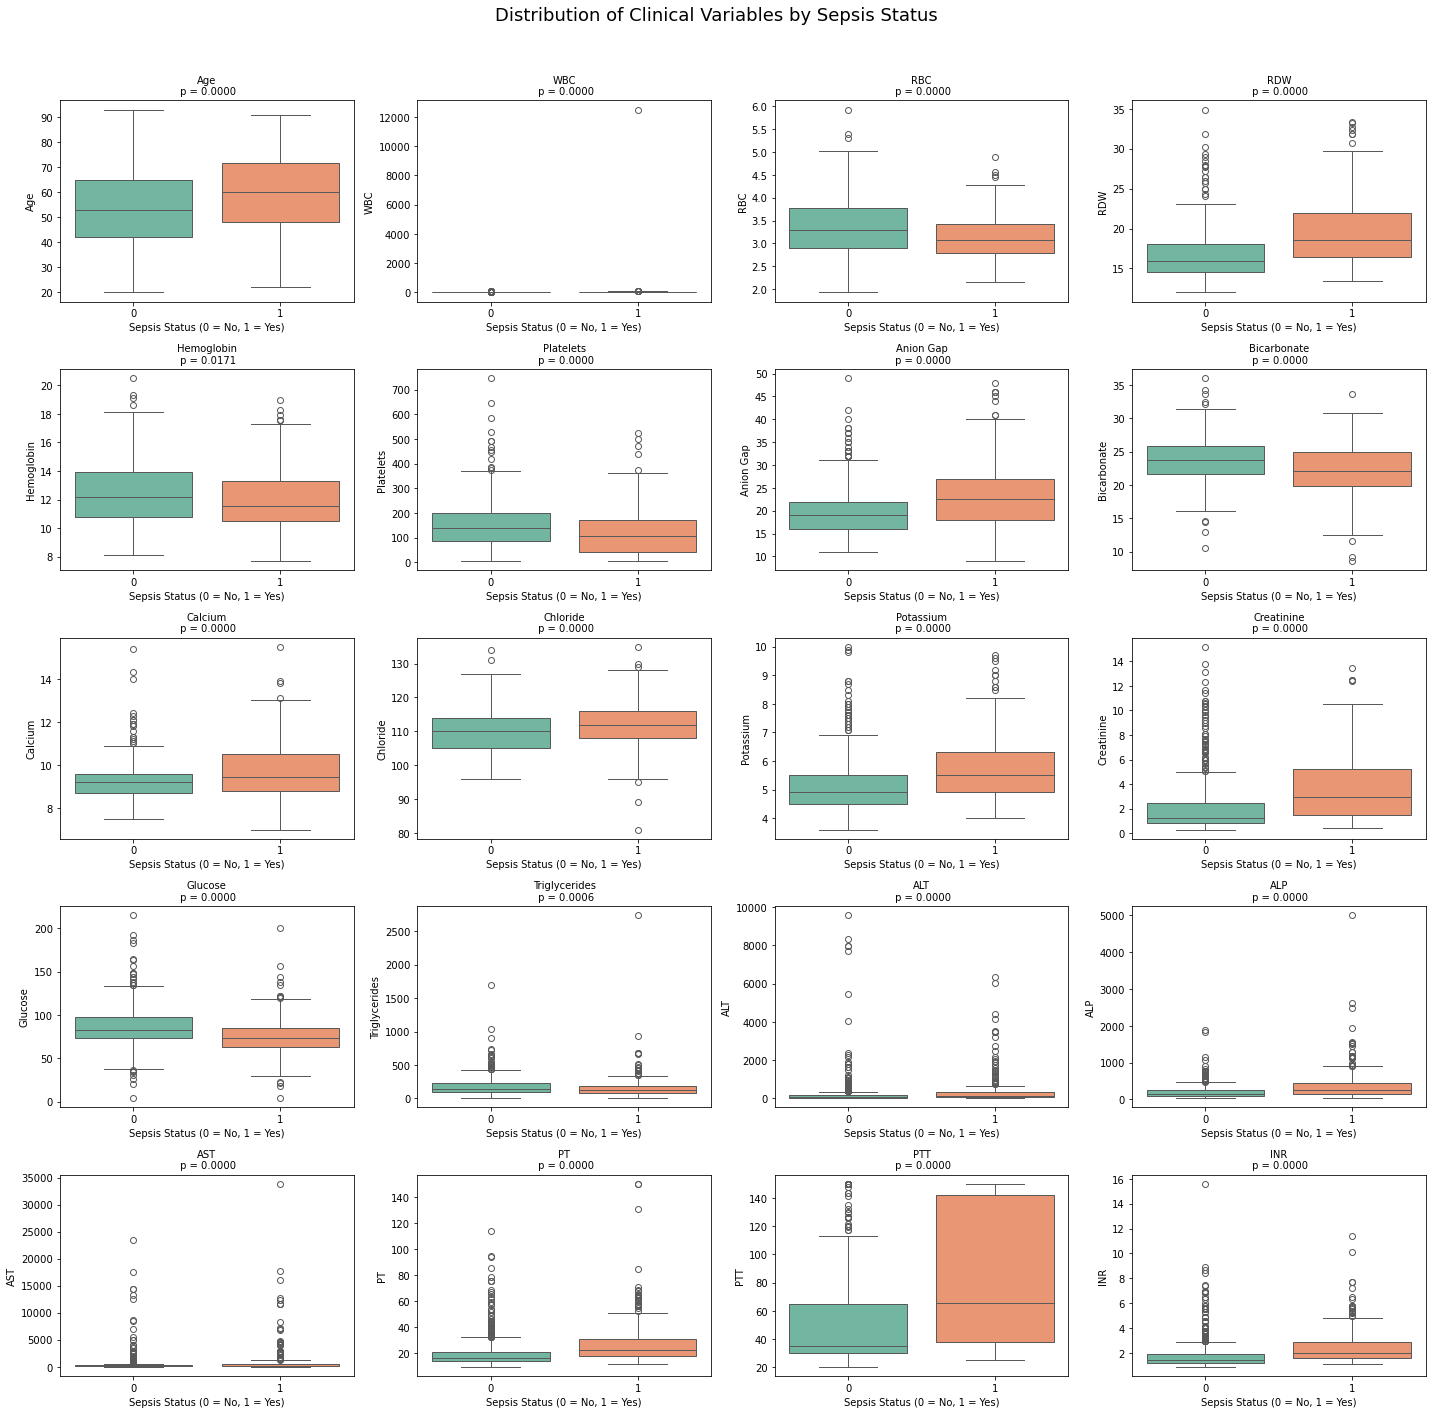

In [4]:
import math
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import mannwhitneyu
import numpy as np

# Các biến muốn so sánh 
cols = [
        'age','wbc', 'rbc', 'rdw', 'hemoglobin',
       'platelets', 'aniongap', 'bicarbonate', 'calcium', 'chloride',
       'potassium', 'creatinine', 'glucose', 'triglycerides', 'alt', 'alp',
       'ast', 'pt', 'ptt', 'inr'
]

titles = [
    'Age', 'WBC', 'RBC','RDW','Hemoglobin','Platelets', 'Anion Gap', 'Bicarbonate',
    'Calcium', 'Chloride', 'Potassium', 'Creatinine', 'Glucose', 'Triglycerides',
    'ALT', 'ALP', 'AST', 'PT', 'PTT', 'INR'
      
]

# Palette cho 2 nhóm
palette = sns.color_palette('Set2', n_colors=2)

# Tính số cột/ hàng cho subplot: cố định 4 cột
ncols = 4
nvars = len(cols)
nrows = math.ceil(nvars / ncols)

# Tạo figure kích thước tự động theo số hàng
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(5 * ncols, 4 * nrows))
axes = np.array(axes).flatten()

for i, col in enumerate(cols):
    ax = axes[i]
    # Vẽ boxplot (không cần hue nếu muốn đơn giản)
    sns.boxplot(
        data=df,
        x='sepsis',
        y=col,
        palette=palette,
        ax=ax,
        showfliers=True  # bạn có thể đặt False để ẩn outliers
    )
    ax.set_ylabel(titles[i])
    ax.set_xlabel('Sepsis Status (0 = No, 1 = Yes)')
    
    # Chuẩn bị nhóm dữ liệu
    group0 = df[df['sepsis'] == 0][col].dropna()
    group1 = df[df['sepsis'] == 1][col].dropna()
    
    # Tính p-value an toàn: kiểm tra đủ mẫu
    p_value = np.nan
    try:
        if len(group0) >= 3 and len(group1) >= 3:
            stat, p_value = mannwhitneyu(group0, group1, alternative='two-sided')
        else:
            p_value = np.nan  # không đủ mẫu để test
    except Exception as e:
        p_value = np.nan
    
    # Hiển thị p-value (hoặc thông báo không thể tính)
    if np.isnan(p_value):
        ax.set_title(f"{titles[i]}\n p = NA", fontsize=10)
    else:
        ax.set_title(f"{titles[i]}\n p = {p_value:.4f}", fontsize=10)

# Ẩn các subplot thừa nếu có
for j in range(nvars, nrows * ncols):
    fig.delaxes(axes[j])

fig.suptitle('Distribution of Clinical Variables by Sepsis Status', fontsize=18)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()


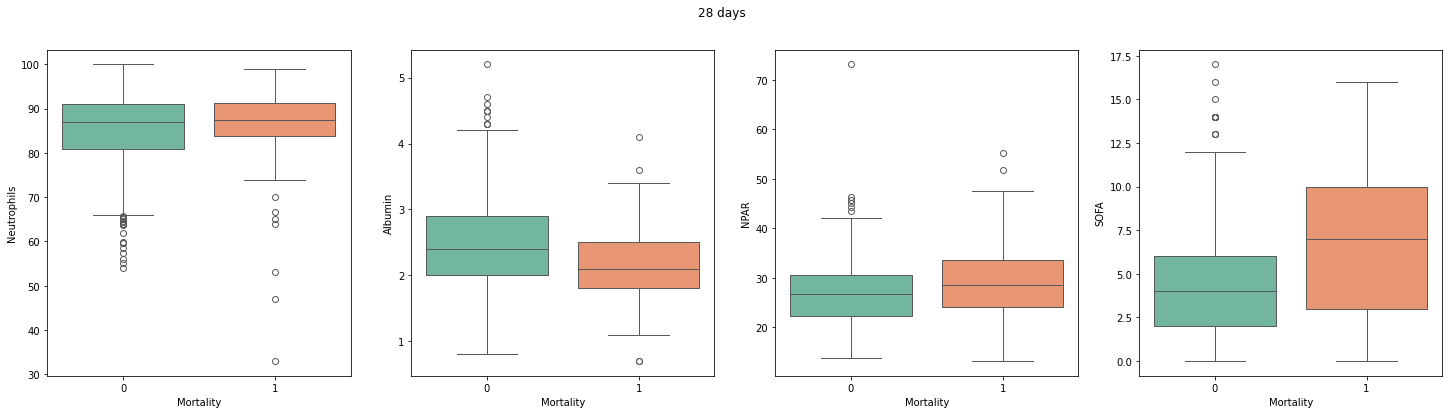

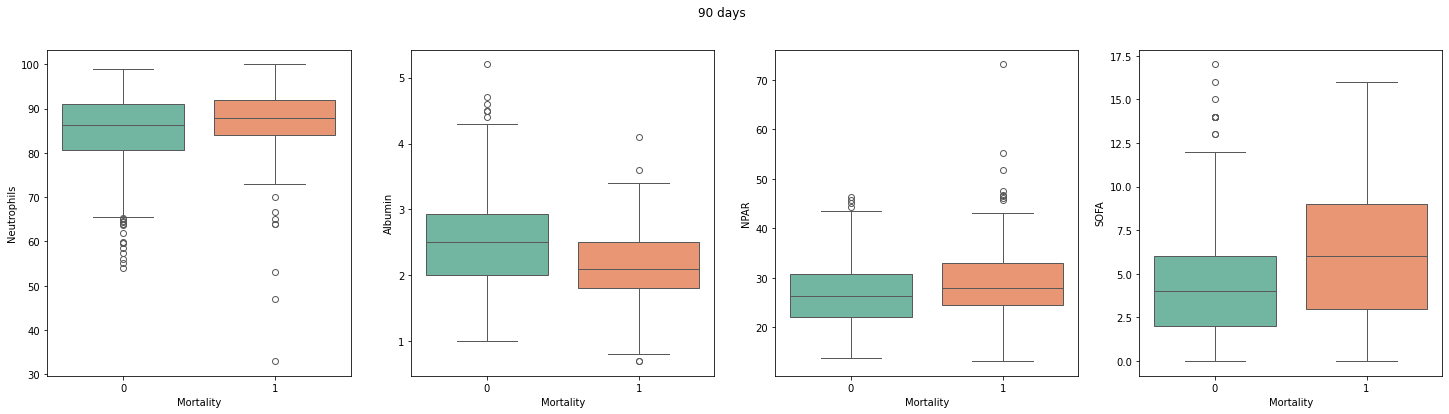

In [5]:
col_mortalities = ['mortality_28d', 'mortality_90d']
days = ['28 days', '90 days']
cols = ['neutrophils_max', 'albumin_min', 'npar', 'sofa']
titles = ['Neutrophils', 'Albumin', 'NPAR', 'SOFA']
palette = sns.palettes.color_palette('Set2', n_colors=2)

for j in range(len(col_mortalities)):
    fig, axes = plt.subplots(ncols=4, nrows=1, figsize=(25, 6))
    for i in range(len(cols)):
        ax = axes[i]
        sns.boxplot(data=df, x=col_mortalities[j], y=cols[i], palette=palette, legend=False, hue=col_mortalities[j], ax=ax)
        # sns.swarmplot(data=df, x=col_mortalities[j], y=cols[i], palette=palette, legend=False, hue=col_mortalities[j], ax=ax)
        # sns.violinplot(data=df, x=col_mortalities[j], y=cols[i], palette=palette, legend=False, hue=col_mortalities[j], ax=ax)
        ax.set_ylabel(titles[i])
        ax.set_xlabel('Mortality')
    fig.suptitle(days[j])
plt.show()


In [6]:
X = df[['tyg']]
y = df['mortality_28d']
X.shape, y.shape

((663, 1), (663,))

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=2026)
rfc = RandomForestClassifier()
rfc.fit(X_train, y_train)
y_prob = rfc.predict_proba(X_test)[:, 1]

fpr, tpr, _ = roc_curve(y_true=y_test, y_score=y_prob)
auc_score = roc_auc_score(y_true=y_test, y_score=y_prob)
auc_score, rfc.score(X_test, y_test)


(0.5349378881987579, 0.7590361445783133)

In [8]:
grid = GridSearchCV(estimator=RandomForestClassifier(random_state=2026),
    param_grid = {
        'criterion': ['gini', 'entropy', 'log_loss'],
        'max_depth': [7, 8, 9, 10],
        'class_weight': ['balanced', 'balanced_subsample'],
        'min_samples_split': [2, 3],
        'min_samples_leaf': [3, 4, 5]
    }, cv=5, verbose=1
)

grid.fit(X_train, y_train)
grid.best_params_, grid.best_score_


Fitting 5 folds for each of 144 candidates, totalling 720 fits


({'class_weight': 'balanced',
  'criterion': 'entropy',
  'max_depth': 10,
  'min_samples_leaf': 3,
  'min_samples_split': 2},
 0.7083232323232324)

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=2026)
rfc = RandomForestClassifier(class_weight='balanced', criterion='entropy', max_depth=10, min_samples_leaf=3, min_samples_split=2)
rfc.fit(X_train, y_train)
y_prob = rfc.predict_proba(X_test)[:, 1]

fpr, tpr, _ = roc_curve(y_true=y_test, y_score=y_prob)
auc_score = roc_auc_score(y_true=y_test, y_score=y_prob)
auc_score, rfc.score(X_test, y_test)

(0.5652173913043478, 0.6867469879518072)

In [10]:
# grid = GridSearchCV(estimator=RandomForestClassifier(random_state=2026),
#     param_grid = {
#         'criterion': ['gini', 'entropy', 'log_loss'],
#         'max_depth': [ 9, 10, 11],
#         'class_weight': ['balanced', 'balanced_subsample'],
#         'min_samples_split': [2, 3],
#         'min_samples_leaf': [3, 4, 5]
#     }, cv=5, verbose=1
# )

# grid.fit(X_train, y_train)
# grid.best_params_, grid.best_score_


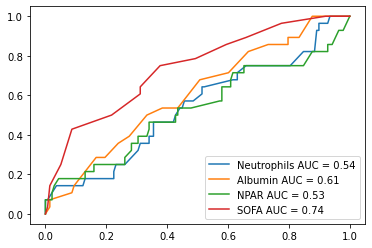

In [11]:
col_mortalities = ['mortality_7d', 'mortality_28d', 'mortality_90d', 'mortality_1y']
days = ['7 days', '28 days', '90 days', '1 year']
cols = ['neutrophils_max', 'albumin_min', 'npar', 'sofa']
titles = ['Neutrophils', 'Albumin', 'NPAR', 'SOFA']
rfc = RandomForestClassifier(class_weight='balanced_subsample', criterion='entropy', max_depth=8, min_samples_leaf=3, min_samples_split=2)

y = df['mortality_28d']
for i in range(len(cols)):
    X = df[[cols[i]]]
    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=2026)
    rfc.fit(X_train, y_train)
    y_prob = rfc.predict_proba(X_test)[:, 1]
    fpr, tpr, _ = roc_curve(y_true=y_test, y_score=y_prob)
    auc_score = roc_auc_score(y_true=y_test, y_score=y_prob)
    plt.plot(fpr, tpr, label=f'{titles[i]} AUC = {auc_score:.2f}')
plt.legend()
plt.show()


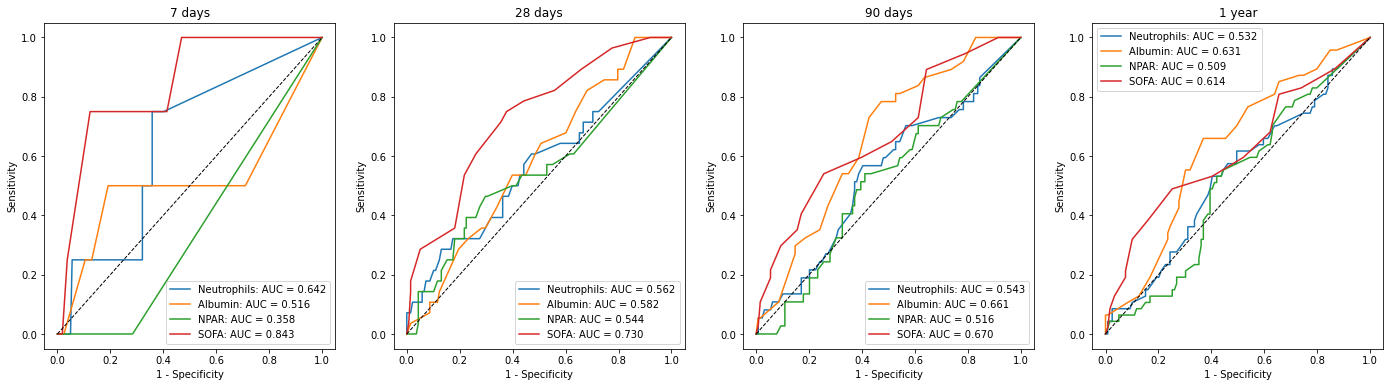

In [12]:
col_mortalities = ['mortality_7d', 'mortality_28d', 'mortality_90d', 'mortality_1y']
days = ['7 days', '28 days', '90 days', '1 year']
cols = ['neutrophils_max', 'albumin_min', 'npar', 'sofa']
titles = ['Neutrophils', 'Albumin', 'NPAR', 'SOFA']
rfc = RandomForestClassifier(random_state=2026)

fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(24, 6))
for j in range(len(days)):
    y = df[col_mortalities[j]]
    ax = axes[j]
    for i in range(len(cols)):
        X = df[[cols[i]]]
        X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=2026)
        rfc.fit(X_train, y_train)
        y_prob = rfc.predict_proba(X_test)[:, 1]
        fpr, tpr, _ = roc_curve(y_true=y_test, y_score=y_prob)
        auc_score = roc_auc_score(y_true=y_test, y_score=y_prob)
        ax.plot(fpr, tpr, label=f'{titles[i]}: AUC = {auc_score:.3f}')
    ax.set_xlabel("1 - Specificity")
    ax.set_ylabel("Sensitivity")
    ax.set_title(days[j])
    ax.plot([0, 1], [0, 1], 'k--', linewidth=1)
    ax.legend()
plt.show()


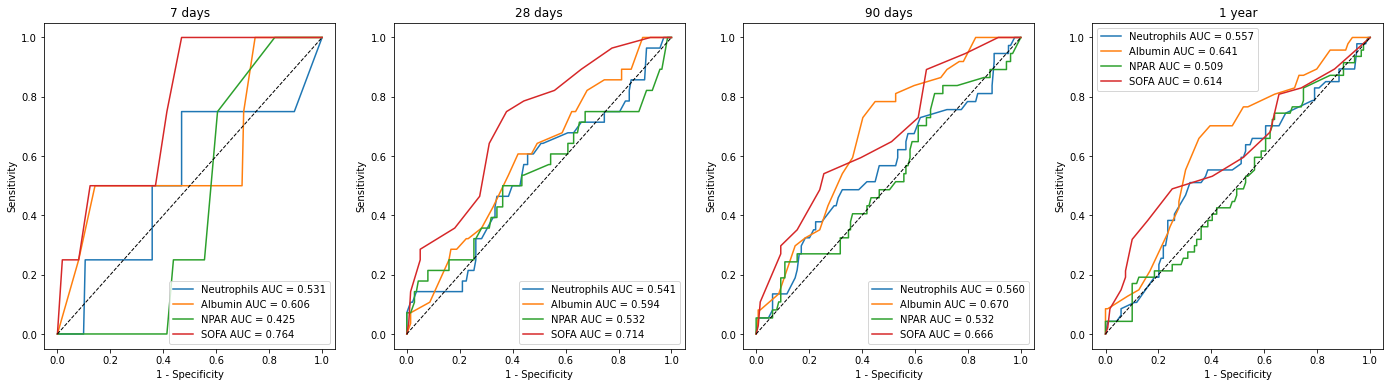

In [13]:
col_mortalities = ['mortality_7d', 'mortality_28d', 'mortality_90d', 'mortality_1y']
days = ['7 days', '28 days', '90 days', '1 year']
cols = ['neutrophils_max', 'albumin_min', 'npar', 'sofa']
titles = ['Neutrophils', 'Albumin', 'NPAR', 'SOFA']

rfc = RandomForestClassifier(
    class_weight='balanced_subsample',
    criterion='entropy',
    max_depth=8,
    min_samples_leaf=3,
    min_samples_split=2,
    random_state=2026
)

fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(24, 6))

for j in range(len(days)):
    y = df[col_mortalities[j]]
    ax = axes[j]
    for i in range(len(cols)):
        X = df[[cols[i]]]
        X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=2026)
        rfc.fit(X_train, y_train)
        y_prob = rfc.predict_proba(X_test)[:, 1]
        fpr, tpr, _ = roc_curve(y_true=y_test, y_score=y_prob)
        auc_score = roc_auc_score(y_true=y_test, y_score=y_prob)
        ax.plot(fpr, tpr, label=f'{titles[i]} AUC = {auc_score:.3f}')
    ax.set_xlabel("1 - Specificity")
    ax.set_ylabel("Sensitivity")
    ax.set_title(days[j])
    ax.plot([0, 1], [0, 1], 'k--', linewidth=1)
    ax.legend()

plt.show()


In [14]:
df['duration_7d'] = np.where((df['mortality_7d'] == 0) & (df['los'] > 7), 7, df['los'])
df['duration_28d'] = np.where((df['mortality_7d'] == 0) & (df['los'] > 28), 28, df['los'])
df['duration_90d'] = np.where((df['mortality_90d'] == 0) & (df['los'] > 90), 90, df['los'])
df['duration_1y']  = np.where((df['mortality_1y']  == 0) & (df['los'] > 365), 365, df['los'])

In [15]:
df['gender_M'] = df['gender'].map({'M': 1, 'F': 0})
df['gender_F'] = df['gender'].map({'M': 0, 'F': 1})

In [16]:
#age < 70
df['age_lt_70'] = df['age'].map(lambda v: 1 if v < 70 else 0)
#age >= 70
df['age_ge_70'] = df['age'].map(lambda v: 1 if v >= 70 else 0)
df.head()

,subject_id,hadm_id,stay_id,intime,age,gender,race,los,diabetes,hypertension,...,mortality_90d,mortality_1y,duration_7d,duration_28d,duration_90d,duration_1y,gender_M,gender_F,age_lt_70,age_ge_70
0,10004606,29242151,30213599,2159-02-20 16:10:03,64,F,WHITE,5.166100,0,1,...,0,0,5.166100,5.166100,5.166100,5.166100,0,1,1,0
1,10006441,24120560,37240744,2174-09-12 16:57:04,51,M,WHITE,0.776481,0,0,...,0,0,0.776481,0.776481,0.776481,0.776481,1,0,1,0
2,10007795,28477357,31921355,2136-04-22 18:01:13,53,F,WHITE,1.050521,0,1,...,0,0,1.050521,1.050521,1.050521,1.050521,0,1,1,0
3,10010888,20162667,33318955,2174-01-09 00:21:00,43,M,WHITE,9.019225,1,0,...,0,0,7.000000,9.019225,9.019225,9.019225,1,0,1,0
4,10012206,23961896,37675714,2127-07-04 02:08:00,45,M,WHITE,0.572477,1,1,...,0,0,0.572477,0.572477,0.572477,0.572477,1,0,1,0


In [17]:
df[['duration_28d', 'mortality_28d', 'gender_M','gender_F', 'npar', 'age_lt_70', 'age_ge_70']].isna().sum()


duration_28d      0
mortality_28d     0
gender_M          0
gender_F          0
npar             67
age_lt_70         0
age_ge_70         0
dtype: int64

In [18]:
df = df[['duration_28d', 'mortality_28d', 'gender_M','gender_F', 'npar', 'age_lt_70', 'age_ge_70']].dropna()


In [19]:
results = []

In [20]:
cph = CoxPHFitter()
cph.fit(df=df, duration_col='duration_28d', event_col='mortality_28d',
        formula='gender_M * npar + age_lt_70 * npar')
cph.summary


,coef,exp(coef),se(coef),coef lower 95%,coef upper 95%,exp(coef) lower 95%,exp(coef) upper 95%,cmp to,z,p,-log2(p)
covariate,,,,,,,,,,,
gender_M,-2.459457,0.085481,0.973638,-4.367753,-0.551161,0.012680,0.576280,0.0,-2.526048,0.011535,6.437792
npar,-0.033730,0.966833,0.035335,-0.102984,0.035525,0.902141,1.036164,0.0,-0.954569,0.339795,1.557261
age_lt_70,-0.965496,0.380794,0.857241,-2.645658,0.714666,0.070959,2.043505,0.0,-1.126283,0.260046,1.943161
gender_M:npar,0.085577,1.089345,0.034284,0.018382,0.152771,1.018552,1.165058,0.0,2.496139,0.012555,6.315554
age_lt_70:npar,0.007725,1.007755,0.027698,-0.046563,0.062013,0.954505,1.063976,0.0,0.278895,0.780325,0.357853


In [21]:
cph.summary.index


Index(['gender_M', 'npar', 'age_lt_70', 'gender_M:npar', 'age_lt_70:npar'], dtype='object', name='covariate')

In [22]:
# index(['gender_M', 'npar', 'age_lt_70', 'age_lt_70:npar'], dtype='object')


In [23]:
hr = cph.summary.loc['gender_M:npar', 'exp(coef)']
ll = cph.summary.loc['gender_M:npar', 'exp(coef) lower 95%']
hl = cph.summary.loc['gender_M:npar', 'exp(coef) upper 95%']
p = cph.summary.loc['gender_M:npar', 'p']
results.append({
    'label': '',
    'group': 'Gender',
    'hr': round(hr,2),
    'll': round(ll,2),
    'hl': round(hl,2),
    'p-value': '',
    'p-interaction': '<0.001' if p < 0.001 else round(p,3)
})
results

[{'label': '',
  'group': 'Gender',
  'hr': 1.09,
  'll': 1.02,
  'hl': 1.17,
  'p-value': '',
  'p-interaction': 0.013}]

In [24]:
cph = CoxPHFitter()
cph.fit(df = df, duration_col = 'duration_28d', event_col = 'mortality_28d', formula = 'gender_M + age_lt_70 + npar')
cph.summary

,coef,exp(coef),se(coef),coef lower 95%,coef upper 95%,exp(coef) lower 95%,exp(coef) upper 95%,cmp to,z,p,-log2(p)
covariate,,,,,,,,,,,
gender_M,-0.034257,0.966323,0.206350,-0.438695,0.370181,0.644877,1.447996,0.0,-0.166015,0.868145,0.203991
age_lt_70,-0.749825,0.472449,0.209485,-1.160408,-0.339242,0.313358,0.712310,0.0,-3.579376,0.000344,11.503561
npar,0.033492,1.034059,0.014553,0.004969,0.062014,1.004982,1.063977,0.0,2.301428,0.021367,5.548441


In [25]:
hr = cph.summary.loc['gender_M', 'exp(coef)']
ll = cph.summary.loc['gender_M', 'exp(coef) lower 95%']
hl = cph.summary.loc['gender_M', 'exp(coef) upper 95%']
p = cph.summary.loc['gender_M', 'p']
results.append({
    'label': 'Male',
    'group': 'Gender',
    'hr': round(hr,2),
    'll': round(ll,2),
    'hl': round(hl,2),
    'p-value': '',
    'p-interaction': '<0.001' if p < 0.001 else round(p,3)
})
results

[{'label': '',
  'group': 'Gender',
  'hr': 1.09,
  'll': 1.02,
  'hl': 1.17,
  'p-value': '',
  'p-interaction': 0.013},
 {'label': 'Male',
  'group': 'Gender',
  'hr': 0.97,
  'll': 0.64,
  'hl': 1.45,
  'p-value': '',
  'p-interaction': 0.868}]

In [26]:
# df['age_ge_70'] = (df['age'] >= 70).astype(int)

In [27]:
cph = CoxPHFitter()
cph.fit(df = df, duration_col = 'duration_28d', event_col = 'mortality_28d', formula = 'gender_F + age_ge_70 + npar')
cph.summary

,coef,exp(coef),se(coef),coef lower 95%,coef upper 95%,exp(coef) lower 95%,exp(coef) upper 95%,cmp to,z,p,-log2(p)
covariate,,,,,,,,,,,
gender_F,0.034257,1.034851,0.206350,-0.370181,0.438695,0.690609,1.550682,0.0,0.166015,0.868145,0.203991
age_ge_70,0.749825,2.116630,0.209485,0.339242,1.160408,1.403884,3.191236,0.0,3.579376,0.000344,11.503561
npar,0.033492,1.034059,0.014553,0.004969,0.062014,1.004982,1.063977,0.0,2.301428,0.021367,5.548441


In [28]:
hr = cph.summary.loc['gender_F', 'exp(coef)']
ll = cph.summary.loc['gender_F', 'exp(coef) lower 95%']
hl = cph.summary.loc['gender_F', 'exp(coef) upper 95%']
p = cph.summary.loc['gender_F', 'p']
results.append({
    'label': 'Female',
    'group': 'Gender',
    'hr': round(hr,2),
    'll': round(ll,2),
    'hl': round(hl,2),
    'p-value': '',
    'p-interaction': '<0.001' if p < 0.001 else round(p,3)
})
results

[{'label': '',
  'group': 'Gender',
  'hr': 1.09,
  'll': 1.02,
  'hl': 1.17,
  'p-value': '',
  'p-interaction': 0.013},
 {'label': 'Male',
  'group': 'Gender',
  'hr': 0.97,
  'll': 0.64,
  'hl': 1.45,
  'p-value': '',
  'p-interaction': 0.868},
 {'label': 'Female',
  'group': 'Gender',
  'hr': 1.03,
  'll': 0.69,
  'hl': 1.55,
  'p-value': '',
  'p-interaction': 0.868}]

In [29]:
import forestplot as fp # type: ignore

df = fp.load_data("sleep")  # companion example data
df.head(3)

,n,r,CI95%,p-val,BF10,power,var,hl,ll,moerror,group,label
0,706,0.090373,[0.02 0.16],0.016309,0.839,0.67,age,0.16,0.02,0.069627,age,in years
1,706,0.048081,[-0.03 0.12],0.201948,0.106,0.25,clerical,0.12,-0.03,0.071919,occupation,=1 if clerical worker
2,706,0.041229,[-0.03 0.11],0.273948,0.086,0.19,construc,0.11,-0.03,0.068771,occupation,=1 if construction worker


<Axes: xlabel='Pearson correlation coefficient'>

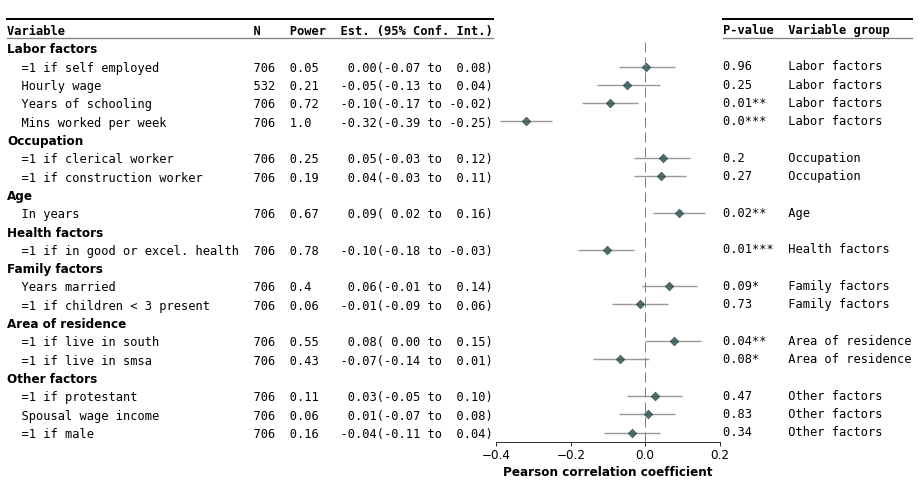

In [30]:
fp.forestplot(df,  # the dataframe with results data
              estimate="r",  # col containing estimated effect size 
              ll="ll", hl="hl",  # lower & higher limits of conf. int.
              varlabel="label",  # column containing the varlabels to be printed on far left
              capitalize="capitalize",  # Capitalize labels
              pval="p-val",  # column containing p-values to be formatted
              annote=["n", "power", "est_ci"],  # columns to report on left of plot
              annoteheaders=["N", "Power", "Est. (95% Conf. Int.)"],  # ^corresponding headers
              rightannote=["formatted_pval", "group"],  # columns to report on right of plot 
              right_annoteheaders=["P-value", "Variable group"],  # ^corresponding headers
              groupvar="group",  # column containing group labels
              group_order=["labor factors", "occupation", "age", "health factors", 
                           "family factors", "area of residence", "other factors"],                   
              xlabel="Pearson correlation coefficient",  # x-label title
              xticks=[-.4,-.2,0, .2],  # x-ticks to be printed
              sort=True,  # sort estimates in ascending order
              table=True,  # Format as a table
              # Additional kwargs for customizations
              **{"marker": "D",  # set maker symbol as diamond
                 "markersize": 35,  # adjust marker size
                 "xlinestyle": (0, (10, 5)),  # long dash for x-reference line 
                 "xlinecolor": "#808080",  # gray color for x-reference line
                 "xtick_size": 12,  # adjust x-ticker fontsize
                }  
              )